In [1]:
import os
import cv2

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.special import gamma,digamma,gammaln

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import math
import matplotlib.pyplot as plt

import numpy.matlib
from numpy.linalg import inv, det
import numpy as np

In [2]:
dir_path = "Project/1/"

images_dir = "data/originalPics/"
fddb_file_path = "data/FDDB-folds/"
img_format = ".jpg"

output_dir = "data/output/"
bbox_fdd_folds = "bbox-FDDB-folds/"
bbox_faces_dir = "faces/"
bbox_non_faces_dir = "non_faces/"
face_dim = (20, 20)

model_path = "models/"

In [3]:
dimensions_after_pca = 100

In [4]:
def get_files(path):
    files = []
    for root, subdirs, images in os.walk(path):
        if images:
            full_path_images = [os.path.join(root, image).replace("\\", "/") for image in images]
            files.extend(full_path_images)
    return files

In [5]:
def data_preparation():
    face_files = get_files(dir_path + output_dir + bbox_faces_dir)
    non_face_files = get_files(dir_path + output_dir + bbox_non_faces_dir)
    
    tr_face_data_images = face_files[:1000] 
    tr_non_face_data_images = non_face_files[:1000]
    
    te_face_data_images = face_files[1000:1100] 
    te_non_face_data_images = non_face_files[1000:1100]
    
    tr_face_data = [cv2.imread(img) for img in tr_face_data_images]
    tr_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in tr_face_data]
    tr_non_face_data = [cv2.imread(img) for img in tr_non_face_data_images]
    tr_non_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in tr_non_face_data]
    
    te_face_data = [cv2.imread(img) for img in te_face_data_images]
    te_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in te_face_data]
    
    te_non_face_data = [cv2.imread(img) for img in te_non_face_data_images]
    te_non_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in te_non_face_data]

    tr_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, \
                                           dtype=cv2.CV_32F).flatten() for i in tr_face_data])
    tr_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,\
                                               dtype=cv2.CV_32F).flatten() for i in tr_non_face_data])
    
    te_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,\
                                           dtype=cv2.CV_32F).flatten() for i in te_face_data])
    te_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,\
                                               dtype=cv2.CV_32F).flatten() for i in te_non_face_data])
    
    tr_face_labels = np.array([1]*1000)
    tr_non_face_labels = np.array([0]*1000)
    
    te_face_labels = np.array([1]*100)
    te_non_face_labels = np.array([0]*100)
    
    return tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, te_face_data, \
te_non_face_data, te_face_labels, te_non_face_labels

In [6]:
tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, \
    te_face_data, te_non_face_data, te_face_labels, te_non_face_labels = data_preparation()
len(tr_face_data), len(tr_non_face_data), len(tr_face_labels), len(tr_non_face_labels), \
    len(te_face_data), len(te_non_face_data), len(te_face_labels), len(te_non_face_labels)

(1000, 1000, 1000, 1000, 100, 100, 100, 100)

In [7]:
def preprocessing(data):
    pca = PCA(n_components=100)
    pca.fit(data)
    pca_data = pca.transform(data)
    std_scaler = StandardScaler()
    std_scaler.fit(pca_data)
    std_data = std_scaler.transform(pca_data)
    return pca, std_data

In [8]:
pca_f, tr_f_data = preprocessing(tr_face_data)
pca_nf, tr_nf_data = preprocessing(tr_non_face_data)
_, te_f_data = preprocessing(te_face_data)
_, te_nf_data = preprocessing(te_non_face_data)

In [9]:
tr_f_data, tr_nf_data, te_f_data, te_nf_data = tr_f_data.T, tr_nf_data.T, te_f_data.T, te_nf_data.T

In [10]:
tr_f_data.shape, tr_nf_data.shape, te_f_data.shape, te_nf_data.shape

((100, 1000), (100, 1000), (100, 100), (100, 100))

In [11]:
K = 40

mean_f = np.mean(tr_f_data,axis=1)
phi_f = np.random.rand(dimensions_after_pca, K)
cov_f = np.random.rand(dimensions_after_pca, dimensions_after_pca)
cov_f = np.diag(np.diag(cov_f))


mean_nf = np.mean(tr_nf_data,axis=1)
phi_nf = np.random.rand(dimensions_after_pca, K)
cov_nf = np.random.rand(dimensions_after_pca, dimensions_after_pca)
cov_nf = np.diag(np.diag(cov_nf))


In [12]:
class Factor_Analyzer():
    def __init__(self, data_size, mean, covs, phi, dimensions, k):
        self.data_size = data_size
        self.mean = mean
        self.covs = covs
        self.phi = phi
        self.dimensions = dimensions
        self.K = k
        
        self.e_of_h = np.zeros((self.data_size, self.K, self.dimensions))
        self.e_of_hi_hit = np.zeros((self.data_size, self.K, self.K))
        
    def EM(self, data):
        term1 = np.matmul(self.phi.T, inv(self.covs))
        term1 = np.matmul(term1, self.phi) + np.eye(self.K)
        term1 = inv(term1)
        temp = np.matmul(term1, self.phi.T)
        term2 = np.matmul(temp, inv(self.covs))
        for i in range(self.data_size):
            self.e_of_h[i] = np.matmul(term2, data[:,i]-self.mean)
            self.e_of_hi_hit[i] = term1 + np.matmul(self.e_of_h[i], self.e_of_h[i].T)
            
        term1 = np.zeros((self.dimensions, self.K))
        term2 = np.zeros((self.K, self.K))
        for i in range(self.data_size):
            term1 += np.matmul((data[:,i]-self.mean), self.e_of_h[i].T)
            term2 += self.e_of_hi_hit[i]
        self.phi = np.matmul(term1, term2)
        
        term = np.zeros((self.dimensions, self.dimensions))
        for i in range(self.data_size):
            term += np.matmul(data[:,i].reshape(-1,1)-self.mean, (data[:,i].reshape(-1,1)-self.mean).T)
            term2 = np.matmul(self.phi, self.e_of_h[i])
            term3 = np.matmul(term2, (data[:,i].reshape(-1,1) - self.mean))
            term = term - term3
        term = term/self.data_size
        self.covs = np.diag(np.diag(term))               
            
    def predict(self, data, row):
        sigma = np.matmul(self.phi, self.phi.T) + self.covs
        term1 = -0.5 * (data[:,row].reshape(-1,1) - self.mean).T
        term2 = inv(sigma)
        term3 = data[:,row].reshape(-1,1) - self.mean
        expo1 = np.matmul(term1,term2)
        expo2 = np.matmul(expo1,term3)[0,0]
        val =  np.exp(expo2)
        det_sigma = det(sigma)
        if det_sigma < 0:
            det_sigma = -det_sigma
        val =  val / np.sqrt(det_sigma)
        return val


In [14]:
factor_analyzer_f = Factor_Analyzer(1000, mean_f.reshape(-1,1), cov_f, phi_f, dimensions_after_pca, K)
factor_analyzer_nf = Factor_Analyzer(1000, mean_nf.reshape(-1,1), cov_nf, phi_nf, dimensions_after_pca, K)

In [24]:
iterations = 10
for i in range(iterations):
    print("Iteration no: {}".format(i))
    factor_analyzer_f.EM(tr_f_data)
    factor_analyzer_nf.EM(tr_nf_data)      

Performing iteration no. 0
Performing iteration no. 1
Performing iteration no. 2
Performing iteration no. 3
Performing iteration no. 4
Performing iteration no. 5
Performing iteration no. 6
Performing iteration no. 7
Performing iteration no. 8
Performing iteration no. 9


In [25]:
pred_f_fdata, pred_f_nfdata, pred_nf_fdata, pred_nf_nfdata = [], [], [], []

for i in range(100):
    pred_f_fdata.append(factor_analyzer_f.predict(te_f_data, i))
    pred_f_nfdata.append(factor_analyzer_f.predict(te_nf_data, i))
    
    pred_nf_fdata.append(factor_analyzer_nf.predict(te_f_data, i))
    pred_nf_nfdata.append(factor_analyzer_nf.predict(te_nf_data, i))

pred_f_fdata = np.array(pred_f_fdata)
pred_f_nfdata = np.array(pred_f_nfdata)
pred_nf_fdata = np.array(pred_nf_fdata)
pred_nf_nfdata = np.array(pred_nf_nfdata)

pred_f_fdata = pred_f_fdata/(pred_f_fdata+pred_f_nfdata)
pred_f_nfdata = pred_f_nfdata/(pred_f_fdata+pred_f_nfdata)
pred_nf_fdata = pred_nf_fdata/(pred_nf_fdata+pred_nf_nfdata)
pred_nf_nfdata = pred_nf_nfdata/(pred_nf_fdata+pred_nf_nfdata)

In [ ]:
pred_f_labels = [1 if pred_f_fdata[i]>pred_nf_fdata[i] else 0 for i in range(100)]
pred_nf_labels = [1 if pred_f_nfdata[i]>pred_nf_nfdata[i] else 0 for i in range(100)]

In [27]:
pred_labels = pred_f_labels + pred_nf_labels
true_labels = [1]*100 + [0]*100

In [28]:
def confusion_matrix(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [29]:
TP, FP, TN, FN = confusion_matrix(true_labels, pred_labels)

In [46]:
fpr =  FP/(FP+TN)
fnr = FN/(TP+FN)
mis_class_rate = (FP + FN)/200
print("False Positive Rate: {}".format(fpr))
print("False Negative Rate: {}".format(fnr))
print("Mis Classification Rate: {}".format(mis_class_rate))

False Positive Rate: 1.0
False Negative Rate: 0.0
Mis Classification Rate: 0.5


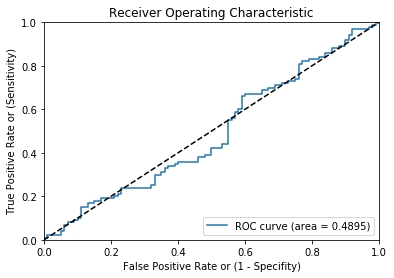

In [31]:
fpr, tpr, threshold = roc_curve([1]*100 + [0]*100, np.append(pred_f_fdata, pred_nf_fdata))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(dir_path + model_path + "T_Distribution/" + "T_Distribution_ROC_Curve.png")

Visualizing Mean


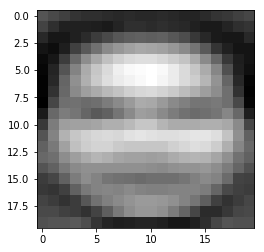

Visualizing Covariance


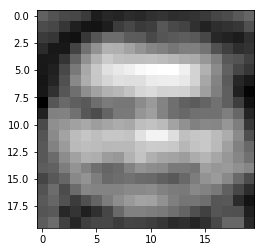

True

In [44]:
print("Visualizing Mean")
mean_f_img = np.dot(factor_analyzer_f.mean[:,0], pca_f.components_) + pca_f.mean_
mean_f_img = np.array(mean_f_img).astype('uint8')
mean_f_img = np.reshape(mean_f_img,(20,20))
plt.imshow(mean_f_img, cmap="gray")
plt.show()
print("Visualizing Covariance")
cov_f_img = np.diagonal(factor_analyzer_f.covs)
cov_f_img = np.matmul(np.log(cov_f_img), pca_f.components_) + pca_f.mean_
cov_f_img =  cov_f_img.reshape(20,20)
plt.imshow(cov_f_img, cmap='gray')
plt.show()


cv2.imwrite(dir_path + model_path + "FA/" + "Mean_Face_Image.jpg", mean_f_img)
cv2.imwrite(dir_path + model_path + "FA/" + "Cov_Face_Image.jpg", cov_f_img) 

cv2.imwrite(dir_path + model_path + "FA/" + "Mean_Face_Image_Resize.jpg", \
            cv2.resize(mean_f_img, (60,60)))
cv2.imwrite(dir_path + model_path + "FA/" + "Cov_Face_Image_Resize.jpg", \
            cv2.resize(cov_f_img, (60,60)))

Visualizing Mean


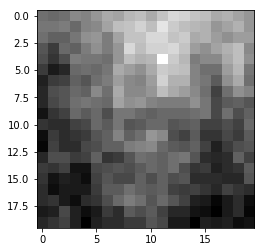

Visualizing Covariance


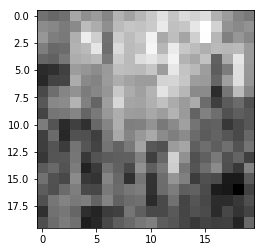

True

In [43]:
print("Visualizing Mean")
mean_f_img = np.dot(factor_analyzer_nf.mean[:,0], pca_f.components_) + pca_f.mean_
mean_f_img = np.array(mean_f_img).astype('uint8')
mean_f_img = np.reshape(mean_f_img,(20,20))
plt.imshow(mean_f_img, cmap="gray")
plt.show()
print("Visualizing Covariance")
cov_f_img = np.diagonal(factor_analyzer_nf.covs)
cov_f_img = np.matmul(np.log(cov_f_img), pca_f.components_) + pca_f.mean_
cov_f_img =  cov_f_img.reshape(20,20)
plt.imshow(cov_f_img, cmap='gray')
plt.show()


cv2.imwrite(dir_path + model_path + "FA/" + "Mean_Non_Face_Image.jpg", mean_f_img)
cv2.imwrite(dir_path + model_path + "FA/" + "Cov_Non_Face_Image.jpg", cov_f_img) 

cv2.imwrite(dir_path + model_path + "FA/" + "Mean_Non_Face_Image_Resize.jpg", \
            cv2.resize(mean_f_img, (60,60)))
cv2.imwrite(dir_path + model_path + "FA/" + "Cov_Non_Face_Image_Resize.jpg", \
            cv2.resize(cov_f_img, (60,60)))